In [114]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

import time

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt

## Simple clustering algorithms comparison

In [115]:
#dowload data
path = "/Users/mikolajmalec/Desktop/Vis_rap_2/sipu/"
a3_df = pd.read_csv( path+"a3.data", header=None, sep = " ")
unbalance_df = pd.read_csv( path+"unbalance.data", header=None, sep = " ")
aggregation_df = pd.read_csv( path+"aggregation.data", header=None, sep = " ")
compound_df = pd.read_csv( path+"compound.data", header=None, sep = " ")
d31_df = pd.read_csv( path+"d31.data", header=None, sep = " ")
flame_df = pd.read_csv( path+"flame.data", header=None, sep = " ")
pathbased_df = pd.read_csv( path+"pathbased.data", header=None, sep = " ")
s4_df = pd.read_csv( path+"s4.data", header=None, sep = " ")

datasets = [ a3_df, unbalance_df, aggregation_df, compound_df, d31_df, flame_df, pathbased_df, s4_df]

#preprocess data, so labels are in 0-1 range
scaler = MinMaxScaler()
for i, df in enumerate(datasets):
    datasets[i] = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [116]:
anomaly_algorithms = [
    ("OneC SVM: rbf", OneClassSVM(kernel="rbf")),
    ("OneC SVM: poly", OneClassSVM(kernel="poly")),
    ("OneC SVM: sigmoid", OneClassSVM(kernel="sigmoid")),
    ("Isol. Forest", IsolationForest()),
    ("LOR: n=10", LocalOutlierFactor(n_neighbors=10)),
    ("LOR: n=20", LocalOutlierFactor(n_neighbors=20)),
    ("LOR: n=30", LocalOutlierFactor(n_neighbors=30)),
]

### One Class SVM

SVMs are max-margin methods, i.e. they do not model a probability distribution. Here the idea is to find a function that is positive for regions with high density of points, and negative for small densities.

rbf: Radial basis function - General-purpose kernel; used when there is no prior knowledge about the data.

poly: Polynomial - It is popular in image processing.

sigmoid: Sigmoid - Used as the proxy for neural networks (simple 2 layers).

### Isolation Forest

“Isolate” outliers by creating decision trees 

### Local Outlier Factor

It considers as outliers the samples that have a substantially lower density than their neighbors. Taking n_neighbors=20 appears to work well in general.

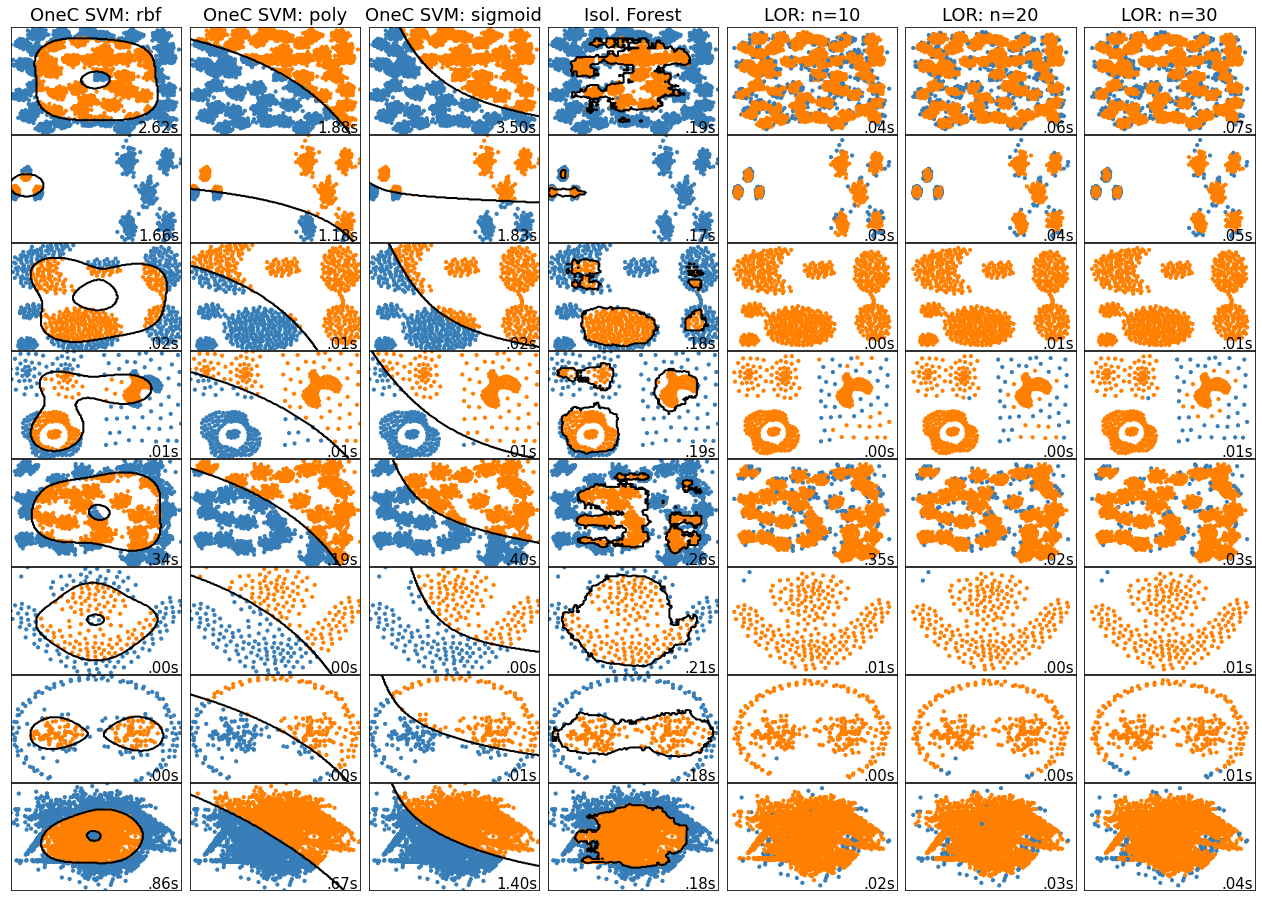

In [117]:
#Most of the code was copied from 
#https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(0, 1, 150), np.linspace(0, 1, 150))

plt.figure(figsize=(len(anomaly_algorithms) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, X in enumerate(datasets):

    for name, algorithm in anomaly_algorithms:
        #mesure time
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        
        plt.subplot(len(datasets), len(anomaly_algorithms), plot_num)
        
        #title for first row
        if i_dataset == 0:
            plt.title(name, size=18)

        # fit the data and tag outliers
        if "LOR" in name:
            y_pred = algorithm.fit_predict(X)
        else:
            y_pred = algorithm.fit(X).predict(X)
        
        # plot the levels lines and the points
        if not "LOR" in name:  # LOF does not implement predict
            Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")
        
        colors = np.array(["#377eb8", "#ff7f00"])
        plt.scatter(X.loc[:, 0], X.loc[:, 1], s=10, color=colors[(y_pred + 1) // 2])

        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1
plt.show()


## Test results

### General

The plots above provide an opportunity to compare the performance of the algorithms based on selected data.  In my opinion, Isolation Forest and Local Outlier Factor were the best performers for the above examples.

### One Class SVM

SVMs failed in my opinion in the above examples. The raf kernel seems to handle the data best, while the other kernels cannot match. I didn't test the linear kernel because none of the above data have linearly separated outliers.

### Isolation Forest

IsolationForest was very sensitive to points and threw most of them away. It is possible that with a change of hyperparameters, it can be made less sensitive.

### Local Outlier Factor

You can see from the examples that increasing n_neighbors makes the model more sensitive to outliers. I think that for the above examples you have worked best.